In [1]:
from platform import python_version
print("Python version: ", python_version())

import numpy as np
print("Numpy version: ", np.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)

dictionary_dir = "data/"

Python version:  3.8.5
Numpy version:  1.24.4
PETITE home directory: /Users/taozhou/Documents/GitHub/PETITE/


In [2]:
from PETITE.dark_shower import *
from PETITE.shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [3]:
# minimum energy = 0.03 GeV, vector mass = 10 MeV
sGraphite = DarkShower(PETITE_home_dir+dictionary_dir, "graphite", 0.030, 0.01, kinetic_mixing=1.0)

In [4]:
# Set up lists to organize data according to BSM process and parent particle
Energies, Weights, particles = {}, {}, {}
parent_pid_options = [11, -11, 22, 111]
for pr in dark_process_codes:
    Energies[pr] = {}
    Weights[pr] = {}
    particles[pr] = {}
    for pid in parent_pid_options:
        Energies[pr][pid] = []
        Weights[pr][pid] = []
        particles[pr][pid] = []

In [10]:
data = np.loadtxt(PETITE_home_dir+dictionary_dir+'Pi0_120GeVProtons_1e3POT.txt')
E = data[:,4]
px = data[:,0]
py = data[:,1]
pz = data[:,2]
POT = 1000
for i in tqdm(range(len(data))):
    p0 = [E[i], px[i], py[i], pz[i]]
    r0 = [0, 0, 0]
    pdict = {"PID":111, "weight":1.0/POT, "stability":"short-lived"}
    part0 = Particle(p0, r0, pdict)
    s0SM = sGraphite.generate_shower(part0)
    s0BSM = sGraphite.generate_dark_shower(ExDir=list(s0SM))
    for p0 in s0BSM[1]:   
        genprocess = p0.get_ids()["generation_process"]
        parent_pid = p0.get_ids()["parent_PID"]

        Energies[genprocess][parent_pid].append(p0.get_p0()[0])
        Weights[genprocess][parent_pid].append(p0.get_ids()["weight"])
        particles[genprocess][parent_pid].append(p0)

100%|██████████| 2831/2831 [2:11:42<00:00,  2.79s/it]  


(0.001, 100.0, 1e-06, 10.0)

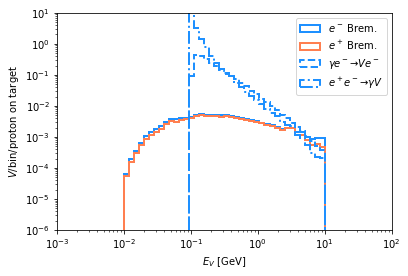

In [12]:
plt.hist(Energies['DarkBrem'][11], weights=Weights['DarkBrem'][11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='dodgerblue', label=r"$e^-\ \mathrm{Brem.}$")
plt.hist(Energies['DarkBrem'][-11], weights=Weights['DarkBrem'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='coral', label=r"$e^+\ \mathrm{Brem.}$")
plt.hist(Energies['DarkComp'][22], weights=Weights['DarkComp'][22], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='--', color='dodgerblue', label=r"$\gamma e^- \to V e^-$")
plt.hist(Energies['DarkAnn'][-11], weights=Weights['DarkAnn'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='-.', color='dodgerblue', label=r"$e^+ e^- \to \gamma V$")
plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_V\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$V/\mathrm{bin}/\mathrm{proton\ on\ target}$")
plt.gca().axis([1e-3, 1e2, 1e-6, 10])

In [1]:
detector_distance = 574 # meters
detector_radius = 2.5 # meters

cut_particles_DarkBrem_electrons = detector_cut(particles['DarkBrem'][11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkBrem_electrons])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkBrem_electrons])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 2, 41), histtype='step', lw=2, color='dodgerblue', label=r"$e^-\ \mathrm{Brem.}$")

cut_particles_DarkBrem_positrons = detector_cut(particles['DarkBrem'][-11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkBrem_positrons])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkBrem_positrons])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 2, 41), histtype='step', lw=2, color='coral', label=r"$e^+\ \mathrm{Brem.}$")

cut_particles_DarkComp = detector_cut(particles['DarkComp'][22], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkComp])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkComp])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 2, 41), histtype='step', lw=2, ls='--', color='dodgerblue', label=r"$\gamma e^- \to V e^-$")

cut_particles_DarkAnn = detector_cut(particles['DarkAnn'][-11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkAnn])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkAnn])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 2, 41), histtype='step', lw=2, ls='-.', color='dodgerblue', label=r"$e^+ e^- \to \gamma V$")

plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_V\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$V/\mathrm{bin}/\mathrm{proton\ on\ target}$")
plt.gca().axis([1e-3, 1e2, 1e-8, 1])

NameError: name 'detector_cut' is not defined